## Dogs v Cats super-charged!

In [78]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [79]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path

if os.name == 'nt':
    PATH = str(Path.home()) + "\\Development\\kaggle\\dogscats\\data\\"
else:
    PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [80]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
print(data)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

ImageClassifierData:path='C:\Users\Christian Klukas\Development\kaggle\dogscats\data\', len(trn_dl)=714, len(val_dl)=180, len(test_dl)=None, bs=28, num_workers=auto-detect, classes=['cat', 'dog']


In [81]:
%time learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.03232  0.02173  0.99266]                                                                                  

Wall time: 4.65 s


In [82]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.0347   0.01494  0.99564]                                                                                  
[ 1.       0.03652  0.01567  0.99583]                                                                                  

Wall time: 6min 26s


In [83]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [84]:
%time learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.04171  0.01553  0.99385]                                                                                  
[ 1.       0.0302   0.01676  0.99385]                                                                                  
[ 2.       0.04074  0.01797  0.99385]                                                                                  

Wall time: 18min 29s


In [85]:
%time learn.save('224_all_50_rxt50')

Wall time: 92.2 ms


In [86]:
%time learn.load('224_all_50_rxt50')

Wall time: 81.2 ms


In [87]:
%time log_preds_augmented,y = learn.TTA()
log_preds = log_preds_augmented.mean(axis=0)
accuracy(log_preds, y)

Wall time: 2min 58s                                                                                                    


0.99522197889707342

## Analyzing results

In [108]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)[0, preds]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[2462   20]
 [   4 2537]]


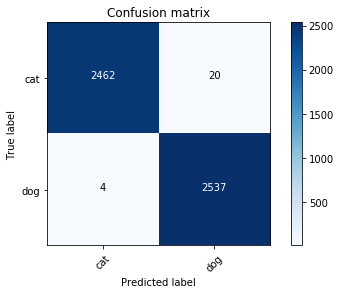

In [109]:
plot_confusion_matrix(cm, data.classes)

In [112]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print("title:", title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

title: Most incorrect cats


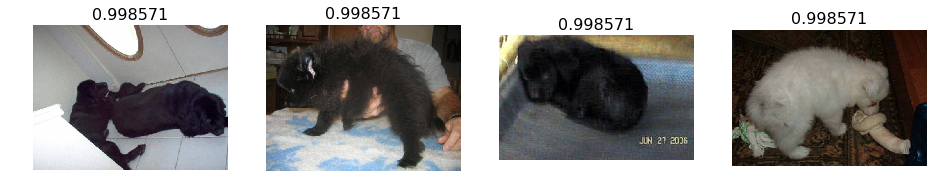

In [113]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

title: Most incorrect dogs


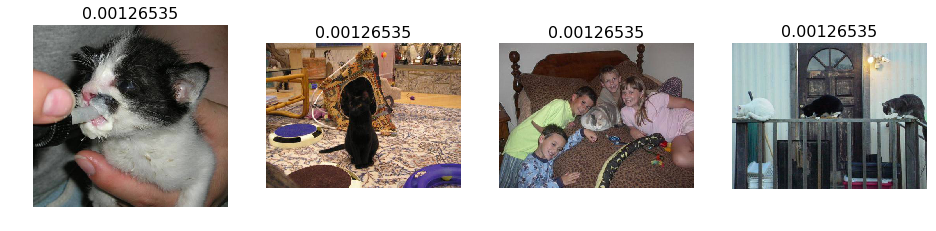

In [114]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")